In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset'

In [4]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [5]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [6]:
classes = list(annotations_dict_train.keys())
print(classes)

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']


In [7]:
from object_detection_helper import GeneratorMultipleOutputs, plot_batch

Using TensorFlow backend.


In [8]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 10, classes = classes,
                                                            concat_output = False
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = classes,
                                                              concat_output = False
                                                         )

Found 1250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


[0.   0.   1.   0.   0.   0.56 0.37 0.85 0.54]


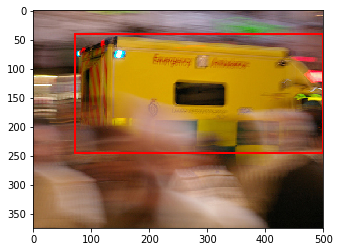

[0.   0.   0.   0.   1.   0.5  0.41 0.77 0.28]


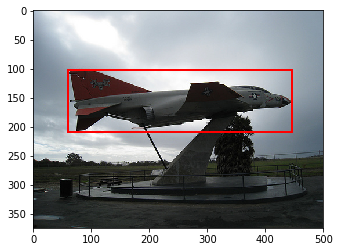

[0.   1.   0.   0.   0.   0.52 0.42 0.47 0.84]


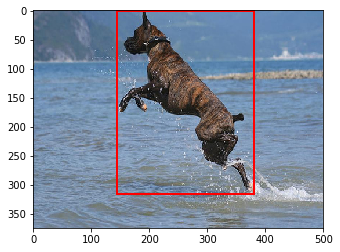

[0.   0.   0.   1.   0.   0.39 0.57 0.38 0.71]


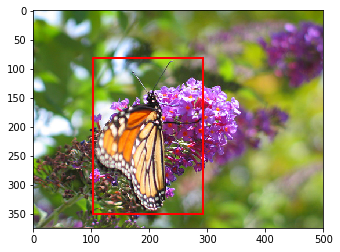

[0.   1.   0.   0.   0.   0.23 0.49 0.46 0.74]


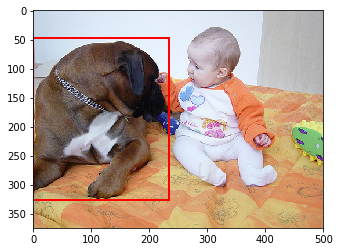

[0.   1.   0.   0.   0.   0.31 0.57 0.45 0.84]


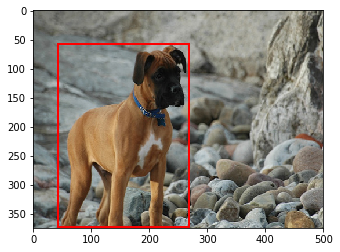

[0.   0.   0.   1.   0.   0.54 0.56 0.84 0.74]


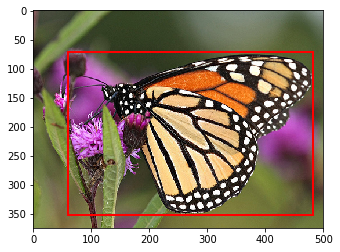

[1.   0.   0.   0.   0.   0.43 0.44 0.55 0.68]


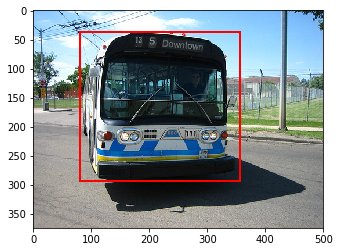

[1.   0.   0.   0.   0.   0.46 0.43 0.32 0.57]


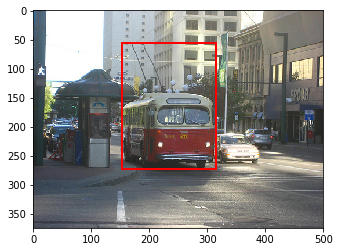

[1.   0.   0.   0.   0.   0.71 0.46 0.37 0.37]


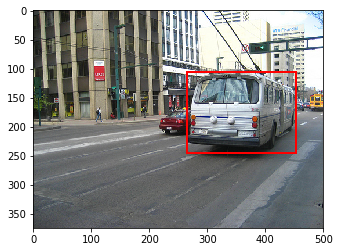

In [9]:
plot_batch(train_generator_multiple_outputs, count=10)

In [23]:
from object_detection_helper import get_VGG16, get_VGG16_no_dense

In [62]:
n_classes = 5
model = get_VGG16_no_dense(n_classes = n_classes, N_trainable = 17)

In [60]:
#n_classes = 5
model = get_VGG16(n_classes = n_classes, N_trainable = 17, dropout_bbox=0, dropout_rate_classif=0, BN=True)

In [63]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 375, 500, 64) 1792        input_21[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 375, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 187, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [64]:
from custom_losses import IOU_loss, iou

In [65]:
losses = {"category_output": "categorical_crossentropy", 
          #"bounding_box": "mean_squared_error"
          "bounding_box": IOU_loss
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, "mae"]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  20.0,
              }

In [66]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, 
                                                            train_folder, 64, classes = classes,
                                                            concat_output = False
                                                           )
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, 
                                                              val_folder, 64, classes = classes,
                                                              concat_output = False
                                                         )

Found 1250 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [67]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_category_output_acc', save_best_only=True)
model.compile(loss=losses,
              optimizer=Adam(lr=0.0001),
              metrics=metrics,
              loss_weights = lossWeights)

In [68]:
from object_detection_helper import PlotLosses

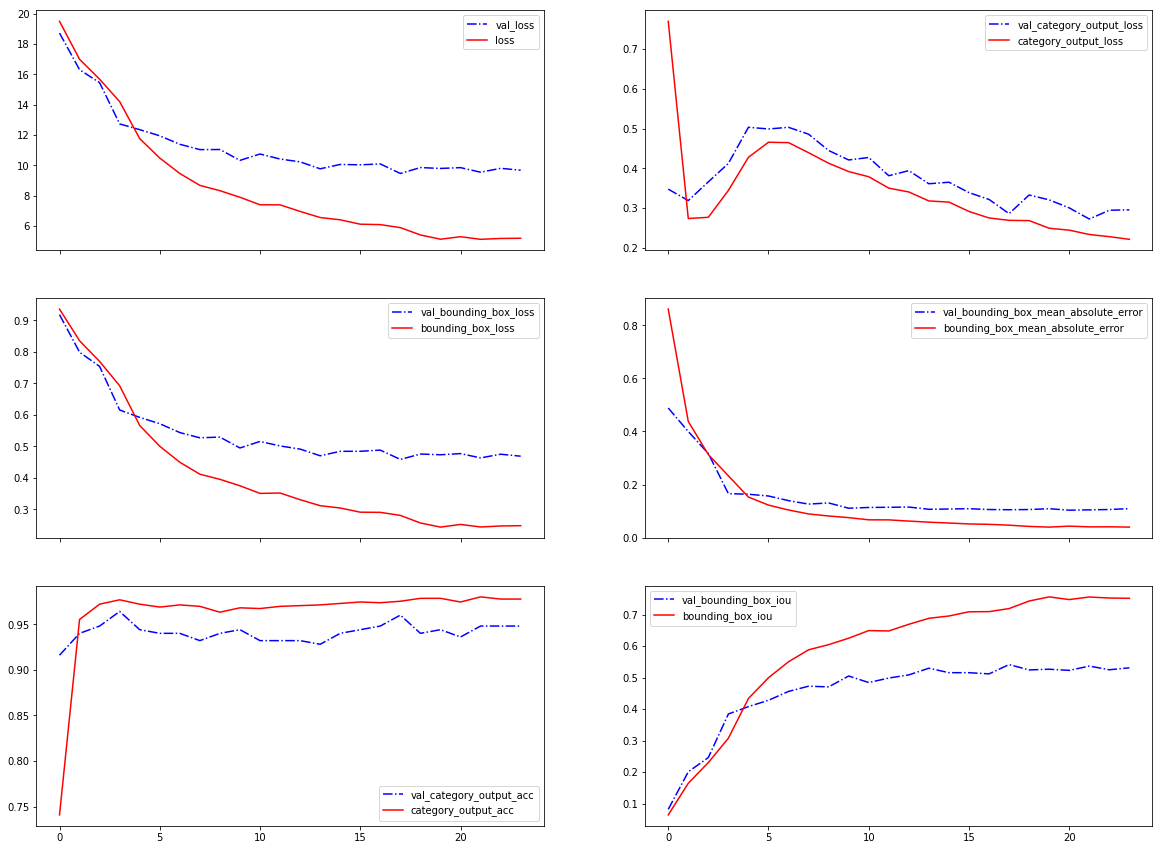

Epoch 25/2000
16/20 [=======================>......] - ETA: 2s - loss: 5.0477 - category_output_loss: 0.2181 - bounding_box_loss: 0.2415 - category_output_acc: 0.9814 - bounding_box_iou: 0.7585 - bounding_box_mean_absolute_error: 0.0398

KeyboardInterrupt: 

In [69]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=2000,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [ ]:
model.load_weights('with_BN.hdf5')

In [76]:
model.evaluate_generator(val_generator_multiple_outputs)

[9.093880577087402,
 0.2424091981649399,
 0.4425735776424408,
 0.9559999957084656,
 0.5574264307022094,
 0.0926241460442543]

Class OK: 2
IOU: [0.83529467]


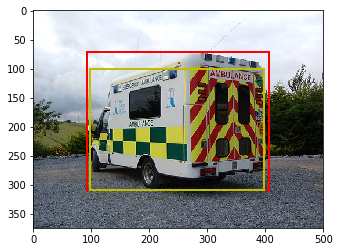

Class OK: 3
IOU: [0.19786872]


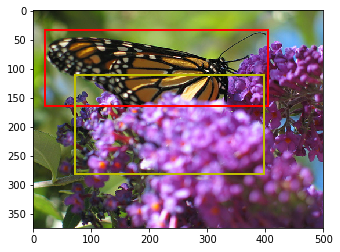

Class OK: 1
IOU: [0.74346696]


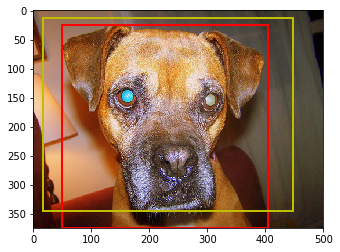

Class OK: 1
IOU: [0.61814407]


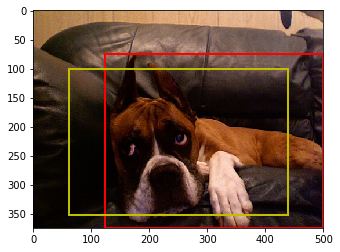

Class OK: 3
IOU: [0.57356164]


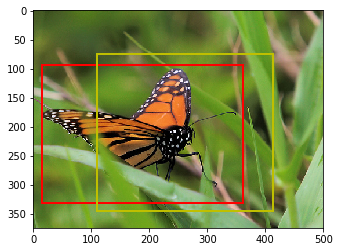

Class OK: 1
IOU: [0.59191148]


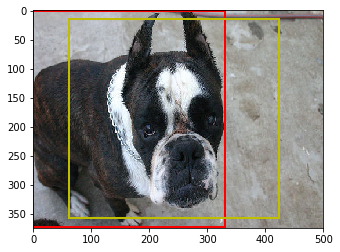

Class OK: 4
IOU: [0.57901166]


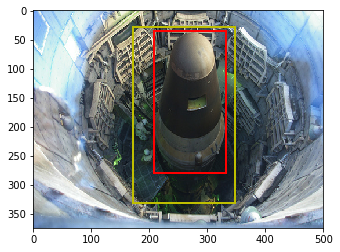

Class OK: 1
IOU: [0.46183707]


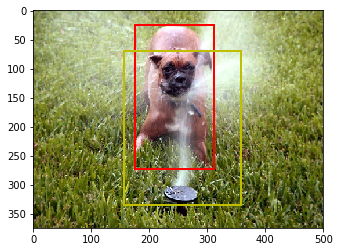

Class OK: 4
IOU: [0.23454625]


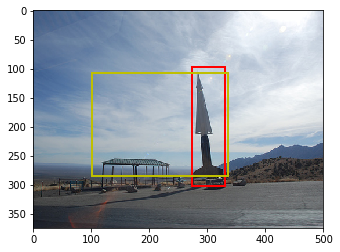

Class OK: 4
IOU: [0.61613065]


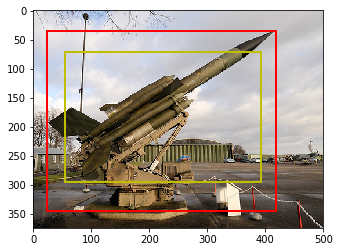

In [113]:
plot_batch(val_generator_multiple_outputs, model, count=10)